<a href="https://colab.research.google.com/github/Ashwin1999/COVID-19-Data-Mining/blob/nivethsaran/COVID_19_Data_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import numpy as np # linear algebra
import warnings
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import datetime
import matplotlib
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
import warnings
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')



matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import dataset from this link: https://github.com/Ashwin1999/COVID-19-Data-Mining

# India Covid Data


In [3]:
indiadaily=pd.read_csv('https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/nation_level_daily.csv')
indiadaily['Date'] = indiadaily['Date'].str.slice(0,6) +' 2020'
indiadaily['Date']= indiadaily['Date'].astype(str).apply(lambda x: datetime.datetime.strptime(x,'%d %b %Y'))
indiadaily['Date']= pd.to_datetime(indiadaily['Date'])
indiadaily.rename(columns={'Daily Confirmed':'casesdaily',
                   'Total Confirmed':'cases',
                   'Daily Recovered':'recoverydaily',
                   'Total Recovered':'recovery', 
                   'Daily Deceased' :'deathdaily',
                   'Total Deceased':'death'},inplace=True)
print(indiadaily.dtypes)
indiadaily.tail()

Date             datetime64[ns]
casesdaily                int64
cases                     int64
recoverydaily             int64
recovery                  int64
deathdaily                int64
death                     int64
dtype: object


,Date,casesdaily,cases,recoverydaily,recovery,deathdaily,death
185,2020-08-02,52672,1804857,40355,1187261,760,38180
186,2020-08-03,50488,1855345,43070,1230331,806,38986
187,2020-08-04,51282,1906627,51220,1281551,849,39835
188,2020-08-05,56626,1963253,45583,1327134,919,40754
189,2020-08-06,62170,2025423,50141,1377275,899,41653


In [4]:
complete = pd.read_csv('https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/complete.csv')
complete['Date']= pd.to_datetime(complete['Date'])
complete.rename(columns={'Name of State / UT':'State'},inplace=True)
complete['Death'] = complete['Death'].str.extract('(\d+)', expand=False)
complete['Death'] = complete['Death'].astype(int)
print(complete.dtypes)
complete.head()

Date                         datetime64[ns]
State                                object
Latitude                            float64
Longitude                           float64
Total Confirmed cases               float64
Death                                 int64
Cured/Discharged/Migrated           float64
New cases                             int64
New deaths                            int64
New recovered                         int64
dtype: object


,Date,State,Latitude,Longitude,Total Confirmed cases,Death,Cured/Discharged/Migrated,New cases,New deaths,New recovered
0,2020-01-30,Kerala,10.8505,76.2711,1.0,0,0.0,0,0,0
1,2020-01-31,Kerala,10.8505,76.2711,1.0,0,0.0,0,0,0
2,2020-02-01,Kerala,10.8505,76.2711,2.0,0,0.0,1,0,0
3,2020-02-02,Kerala,10.8505,76.2711,3.0,0,0.0,1,0,0
4,2020-02-03,Kerala,10.8505,76.2711,3.0,0,0.0,0,0,0


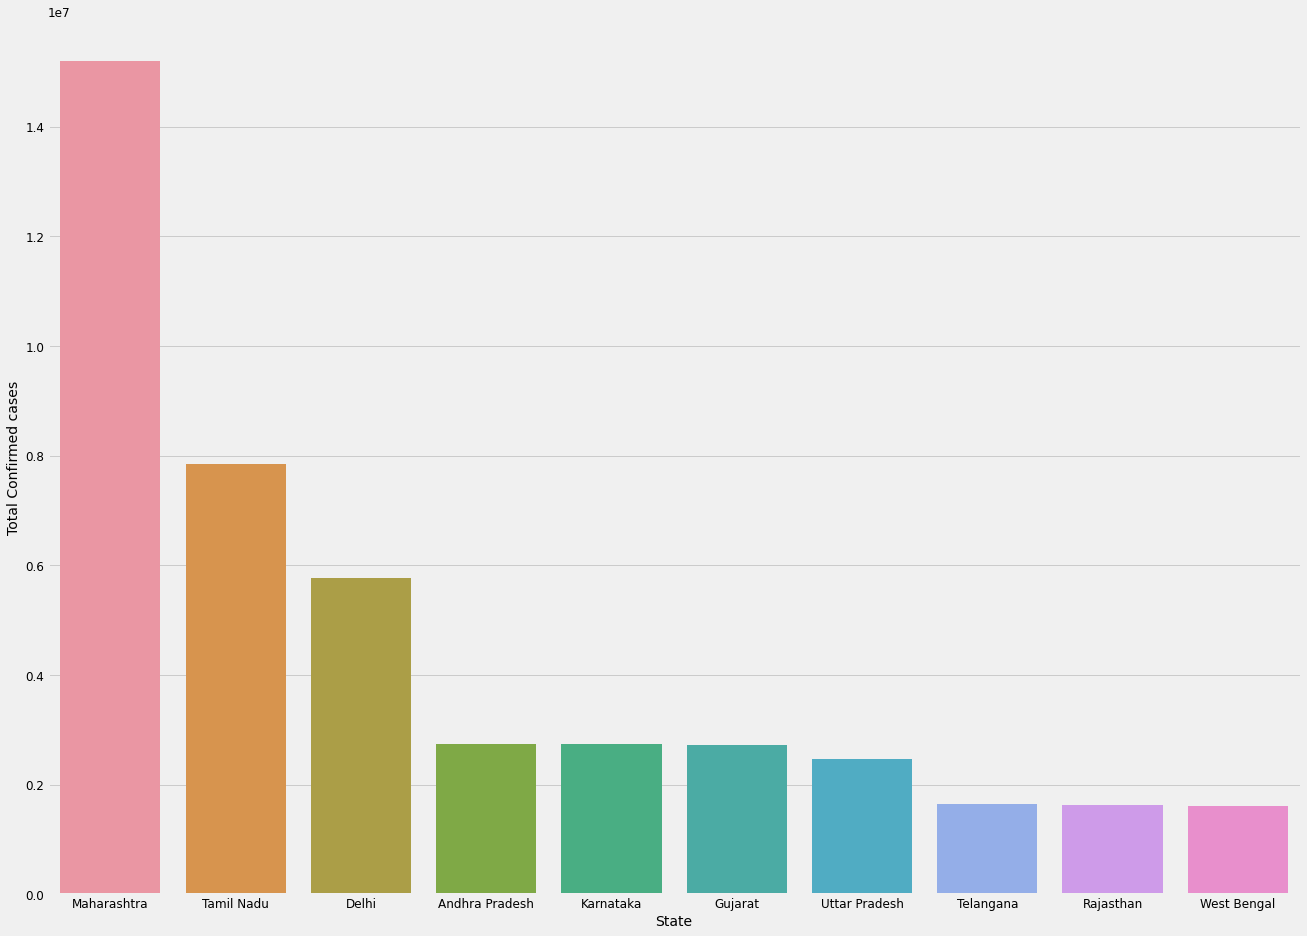

In [5]:
plt.figure(figsize=(20,15))
statewisedata=complete.groupby('State').sum()
statewisedata.reset_index(inplace=True)
statewisedata.sort_values(by='Total Confirmed cases',inplace=True,ascending=False)
sns.barplot(y='Total Confirmed cases',x='State',data=statewisedata.iloc[:10])
# # statewisedata.plot.bar(rot=0,figsize=(20,10))
# # statewisedata.plot.bar(rot=0,figsize=(20,10))

# plt.xticks(rotation=70)
# statewisedata.head()

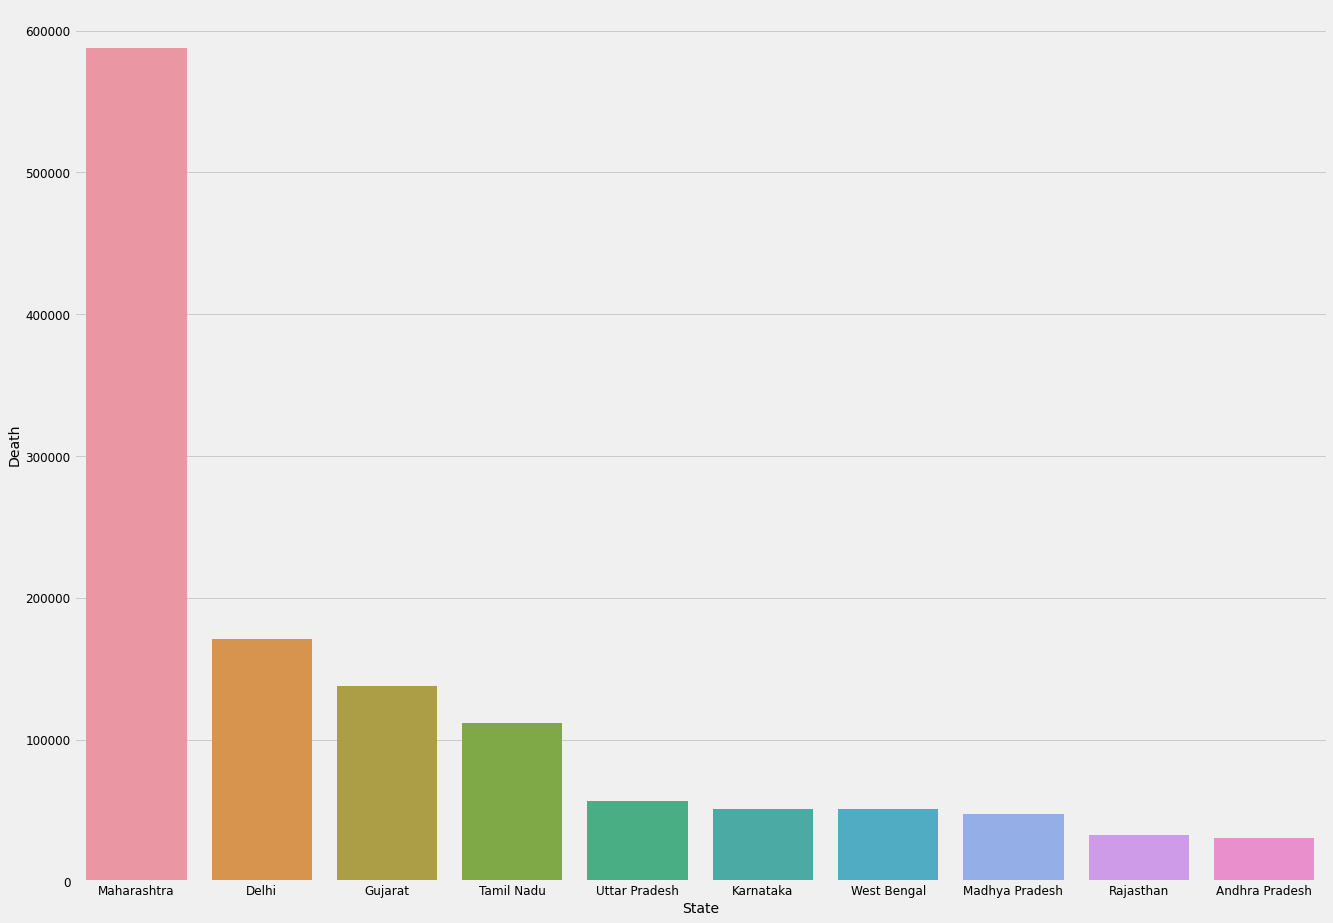

In [6]:
plt.figure(figsize=(20,15))
statewisedata=complete.groupby('State').sum()
statewisedata.reset_index(inplace=True)
statewisedata.sort_values(by='Death',inplace=True,ascending=False)
sns.barplot(y='Death',x='State',data=statewisedata.iloc[:10])

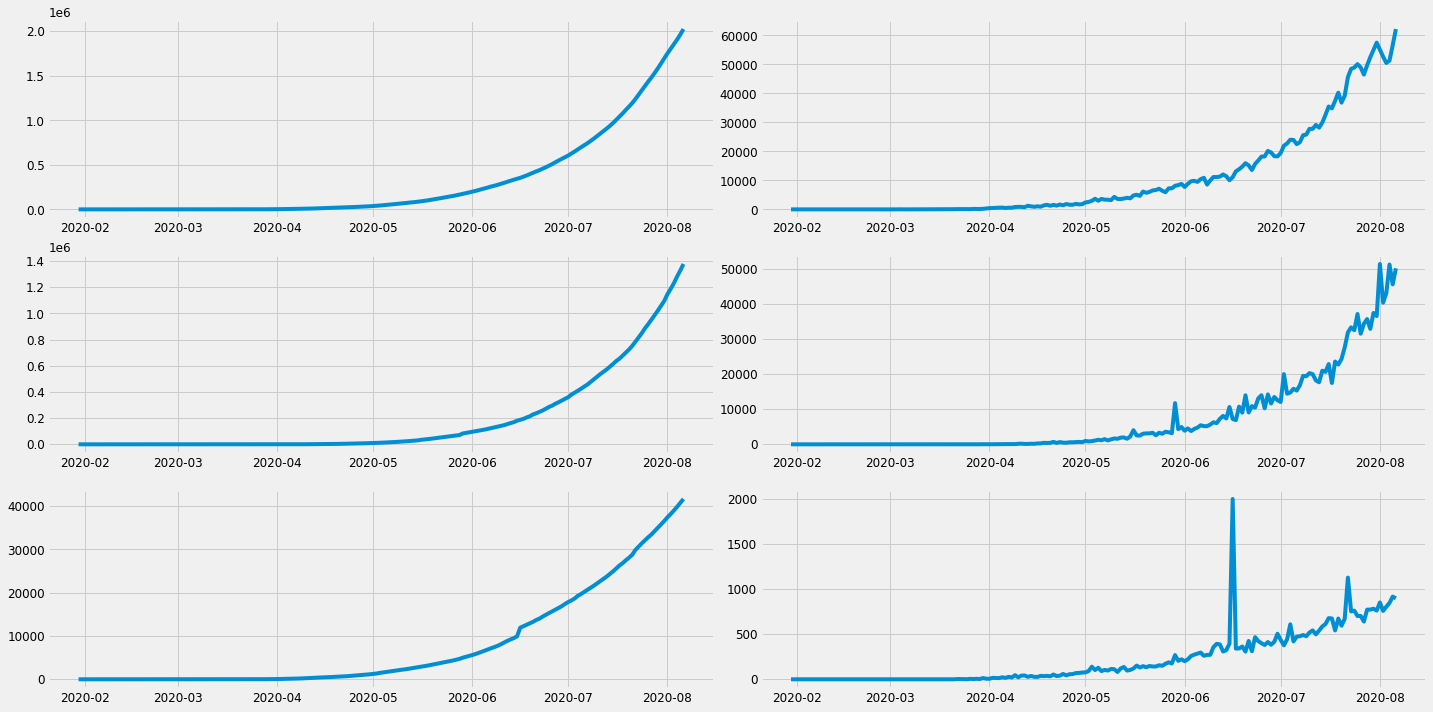

In [7]:
fig,ax=plt.subplots(3,2,figsize=(20,10))
fig.tight_layout()
ax[0,0].plot(indiadaily['Date'],indiadaily['cases'])
ax[0,1].plot(indiadaily['Date'],indiadaily['casesdaily'])
ax[1,0].plot(indiadaily['Date'],indiadaily['recovery'])
ax[1,1].plot(indiadaily['Date'],indiadaily['recoverydaily'])
ax[2,0].plot(indiadaily['Date'],indiadaily['death'])
ax[2,1].plot(indiadaily['Date'],indiadaily['deathdaily'])

# plt.plot(indiadaily['Date'],indiadaily['Total Recovered'])
# plt.plot(indiadaily['Date'],indiadaily['Total Deceased'])

In [8]:
indiatesting=pd.read_csv('https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/tests_day_wise.csv')
indiatesting=indiatesting[['Tested As Of','Total Samples Tested']]
indiatesting['Tested As Of']=indiatesting['Tested As Of'].str.replace('/','-')
indiatesting.rename(columns={'Tested As Of':'Date','Total Samples Tested':'tests'},inplace=True)
indiatesting.dropna(how='any',axis=0,inplace=True)
indiatesting['Date']= indiatesting['Date'].astype(str).apply(lambda x: datetime.datetime.strptime(x,'%d-%m-%Y'))
indiatesting['Date']= pd.to_datetime(indiatesting['Date'])
indiatesting.head()

,Date,tests
0,2020-03-13,6500.0
1,2020-03-18,13125.0
2,2020-03-19,13316.0
3,2020-03-19,14175.0
4,2020-03-20,14376.0


In [21]:
indiacovidfinal.columns

Index(['casesdaily', 'cases', 'recoverydaily', 'recovery', 'deathdaily',
       'death', 'tests'],
      dtype='object')

In [24]:
indiacovidfinal = indiadaily.merge(indiatesting,how='inner',on='Date')

indiacovidfinal = indiacovidfinal[['Date','casesdaily', 'recoverydaily', 'recovery', 'deathdaily','death', 'tests', 'cases']]
indiacovidfinal.tail()

,Date,casesdaily,recoverydaily,recovery,deathdaily,death,tests,cases
141,2020-08-01,55117,51368,1146906,854,37420,19821831.0,1752185
142,2020-08-02,52672,40355,1187261,760,38180,20202858.0,1804857
143,2020-08-03,50488,43070,1230331,806,38986,20864750.0,1855345
144,2020-08-04,51282,51220,1281551,849,39835,21484402.0,1906627
145,2020-08-05,56626,45583,1327134,919,40754,22149351.0,1963253


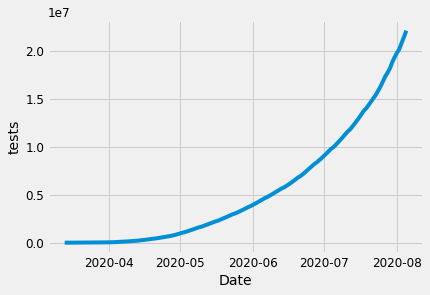

In [10]:
sns.lineplot(x='Date',y='tests',data=indiacovidfinal)

# US COVID Data

In [ ]:
usdaily=pd.read_csv('https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/master/OtherDatasets/US_National_History_Final.csv')
usdaily.rename(columns={'date':'Date'},inplace=True)
# indiadaily['Date'] = indiadaily['Date'].str.slice(0,6) +' 2020'
# indiadaily['Date']= indiadaily['Date'].astype(str).apply(lambda x: datetime.datetime.strptime(x,'%d %b %Y'))
usdaily['Date']= pd.to_datetime(usdaily['Date'])
print(usdaily.dtypes)
usdaily.sort_values('Date',ascending=True,inplace=True)
usdaily.fillna(0,inplace=True)
usdaily.head()

Date                        datetime64[ns]
death                              float64
deathIncrease                        int64
inIcuCumulative                    float64
inIcuCurrently                     float64
hospitalizedIncrease                 int64
hospitalizedCurrently              float64
hospitalizedCumulative             float64
negative                             int64
negativeIncrease                     int64
onVentilatorCumulative             float64
onVentilatorCurrently              float64
posNeg                               int64
positive                             int64
positiveIncrease                     int64
recovered                          float64
states                               int64
totalTestResults                     int64
totalTestResultsIncrease             int64
dtype: object


,Date,death,deathIncrease,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCumulative,onVentilatorCurrently,posNeg,positive,positiveIncrease,recovered,states,totalTestResults,totalTestResultsIncrease
271,2020-01-22,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,2,1,0
270,2020-01-23,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,2,2,1
269,2020-01-24,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,2,2,0
268,2020-01-25,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,2,2,0
267,2020-01-26,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,2,2,0


In [ ]:
usdaily=usdaily[['Date', 'death', 'inIcuCurrently',
       'hospitalizedCurrently', 'negative',
       'onVentilatorCurrently', 'positive',
       'recovered','totalTestResults']]
usdaily.columns

Index(['Date', 'death', 'inIcuCurrently', 'hospitalizedCurrently', 'negative',
       'onVentilatorCurrently', 'positive', 'recovered', 'totalTestResults'],
      dtype='object')

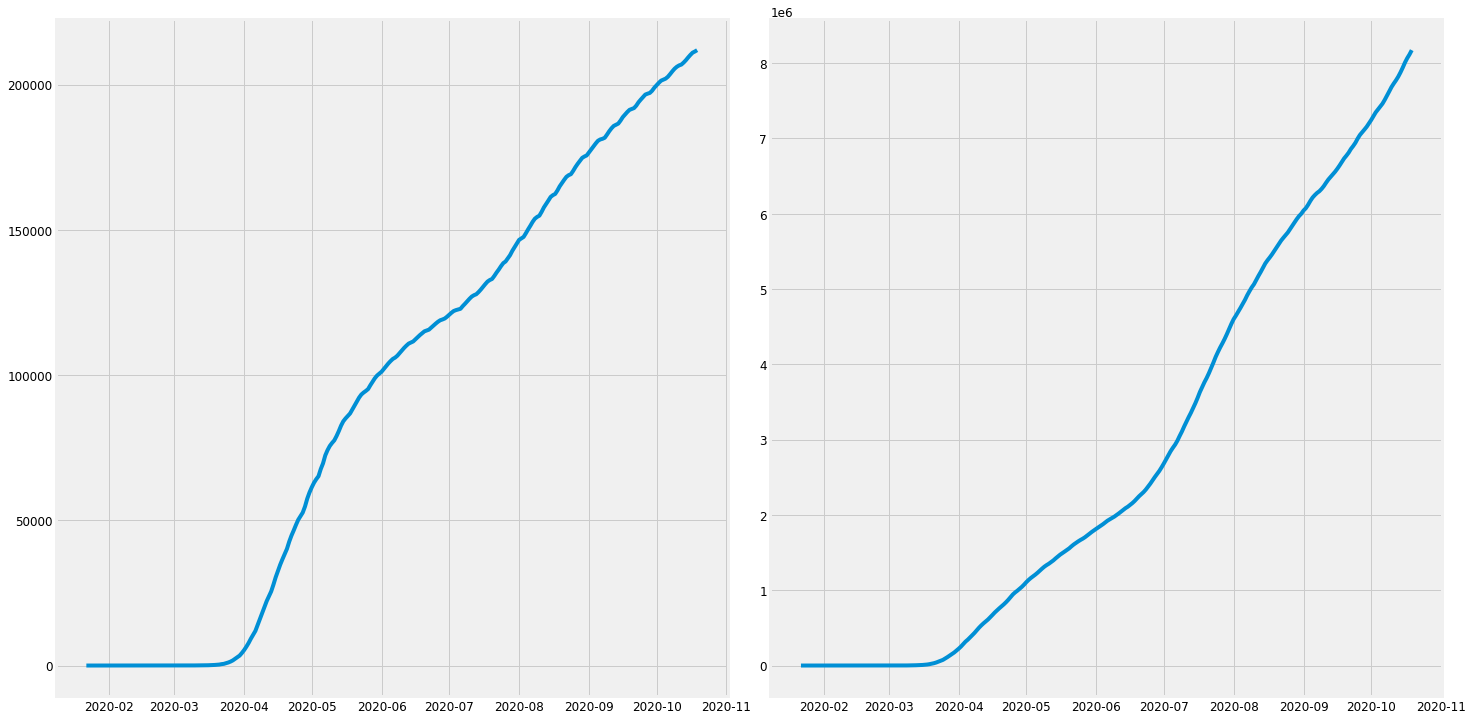

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
fig.tight_layout()
ax[0].plot(usdaily['Date'],usdaily['death'])
ax[1].plot(usdaily['Date'],usdaily['positive'])

# EDA



In [25]:
indiacovidfinal=indiacovidfinal.groupby('Date').sum()
indiacovidfinal.sort_index(inplace= True)
indiacovidfinal.head()

,casesdaily,recoverydaily,recovery,deathdaily,death,tests,cases
Date,,,,,,,
2020-03-13,10,6,10,0,1,6500.0,91
2020-03-18,25,0,15,0,3,13125.0,171
2020-03-19,54,10,40,2,8,27491.0,396
2020-03-20,116,6,46,0,8,29780.0,512
2020-03-21,156,0,46,0,8,32612.0,668


<Figure size 720x720 with 0 Axes>

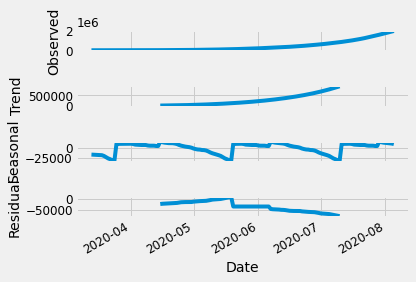

In [12]:
plt.figure(figsize=(10,10))
toplot=indiacovidfinal['cases']
result = seasonal_decompose(toplot, model='additive',freq=52)
result.plot()
plt.show()

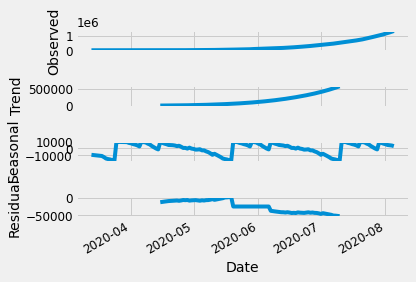

In [13]:
toplot=indiacovidfinal['recovery']
result = seasonal_decompose(toplot, model='additive',freq=52)
result.plot()
plt.show()

# Stationarity Testing

In [14]:
result = adfuller(indiacovidfinal['cases'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 3.495026
p-value: 1.000000
	1%: -3.483
	5%: -2.885
	10%: -2.579


In [16]:
result = adfuller(indiacovidfinal['death'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 18.247325
p-value: 1.000000
	1%: -3.479
	5%: -2.883
	10%: -2.578


# LSTM

In [28]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(indiacovidfinal)

In [30]:
# split into train and test sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
print(train.shape)
print(test.shape)

110 28
(110, 7)
(28, 7)


In [89]:
trainX, trainY = train[:,0:6],train[:,6]
testX, testY = test[:,0:6],test[:,6]

In [127]:
# trainY = np.insert(trainY, 0, 0)
# define generator
n_input = 1
generator = TimeseriesGenerator(trainX, trainY, length=n_input, batch_size=1)
generator_test = TimeseriesGenerator(testX, testY, length=n_input, batch_size=1)

In [91]:
n_features = 6
# trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))

In [104]:
lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse',metrics='mse')
lstm_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 200)               165600    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 201       
Total params: 165,801
Trainable params: 165,801
Non-trainable params: 0
_________________________________________________________________


In [108]:
lstm_model.fit_generator(generator=generator,epochs=20)

Epoch 1/20
109/109 [==============================] - 0s 2ms/step - loss: 3.9307e-05 - mse: 3.9307e-05
Epoch 2/20
109/109 [==============================] - 0s 2ms/step - loss: 1.5484e-05 - mse: 1.5484e-05
Epoch 3/20
109/109 [==============================] - 0s 2ms/step - loss: 4.2659e-05 - mse: 4.2659e-05
Epoch 4/20
109/109 [==============================] - 0s 2ms/step - loss: 1.9148e-05 - mse: 1.9148e-05
Epoch 5/20
109/109 [==============================] - 0s 2ms/step - loss: 2.5350e-05 - mse: 2.5350e-05
Epoch 6/20
109/109 [==============================] - 0s 2ms/step - loss: 2.7080e-05 - mse: 2.7080e-05
Epoch 7/20
109/109 [==============================] - 0s 2ms/step - loss: 2.2154e-05 - mse: 2.2154e-05
Epoch 8/20
109/109 [==============================] - 0s 2ms/step - loss: 2.6766e-05 - mse: 2.6766e-05
Epoch 9/20
109/109 [==============================] - 0s 2ms/step - loss: 1.7849e-05 - mse: 1.7849e-05
Epoch 10/20
109/109 [==============================] - 0s 2ms/step - loss

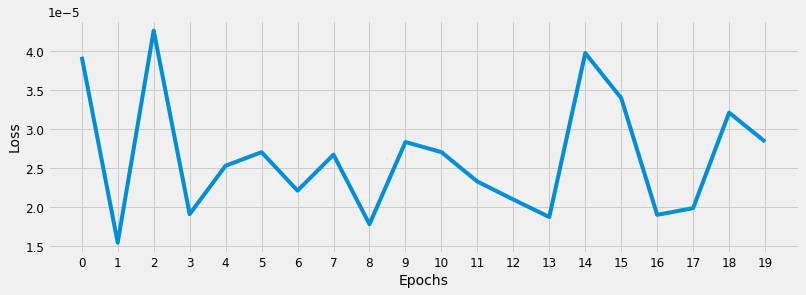

In [110]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [132]:
lstm_model.predict(generator_test)

(array([[0.41091758],
        [0.42816854],
        [0.43929794],
        [0.44916025],
        [0.45732284],
        [0.4778904 ],
        [0.49720597],
        [0.52149296],
        [0.52593654],
        [0.5475675 ],
        [0.570741  ],
        [0.57347983],
        [0.59956986],
        [0.65092874],
        [0.66769975],
        [0.68677366],
        [0.7105807 ],
        [0.72224694],
        [0.734553  ],
        [0.7690511 ],
        [0.7946515 ],
        [0.83010316],
        [0.8582803 ],
        [0.89154744],
        [0.8926825 ],
        [0.9160094 ],
        [0.95554894]], dtype=float32),
 array([0.40483465, 0.41897612, 0.43311505, 0.44794113, 0.4622945 ,
        0.47753369, 0.49414312, 0.51220989, 0.52994659, 0.54900309,
        0.56949809, 0.58824641, 0.60819892, 0.63142726, 0.65610327,
        0.68100595, 0.70651174, 0.73143684, 0.75511496, 0.78039612,
        0.80712799, 0.83512772, 0.86441007, 0.89248569, 0.91931588,
        0.94503357, 0.97115572, 1.        ]))

In [138]:
output=lstm_model.predict(generator_test)
# scaler.inverse_transform(np.hstack(Xtest,lstm_model.predict(generator_test)))
outputDf = scaler.inverse_transform(np.hstack((testX[0:len(testX)-1],output)))
# indiacovidfinal['predictedcases']=outputDf[:-1]
# indiacovidfinal.head()

ValueError: ignored